## Part 1: Load Data

Load the three main data files into memory for exploration.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Set style for visualizations
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Resolve project root (notebook is in notebooks/ folder)
notebook_dir = Path(os.getcwd())
if notebook_dir.name == 'notebooks':
    project_root = notebook_dir.parent
else:
    project_root = notebook_dir

print(f'✅ Project root: {project_root}')
print('✅ Libraries loaded successfully')

✅ Project root: D:\TUNVESTI\TUNVESTI
✅ Libraries loaded successfully


In [2]:
# Define paths using project root
output_dir = project_root / 'output'

# Verify files exist
fact_path = output_dir / 'fact_stock_daily.csv'
dim_date_path = output_dir / 'dim_date.csv'
dim_stock_path = output_dir / 'dim_stock.csv'

if not fact_path.exists():
    raise FileNotFoundError(f"❌ Missing: {fact_path}")
if not dim_date_path.exists():
    raise FileNotFoundError(f"❌ Missing: {dim_date_path}")
if not dim_stock_path.exists():
    raise FileNotFoundError(f"❌ Missing: {dim_stock_path}")

# Load data files
try:
    fact = pd.read_csv(fact_path)
    dim_date = pd.read_csv(dim_date_path)
    dim_stock = pd.read_csv(dim_stock_path)
    
    # Convert date columns
    fact['date'] = pd.to_datetime(fact['date'])
    dim_date['date'] = pd.to_datetime(dim_date['date'])
    
    print(f'✅ fact_stock_daily.csv: {len(fact):,} rows × {len(fact.columns)} columns')
    print(f'✅ dim_date.csv: {len(dim_date):,} rows × {len(dim_date.columns)} columns')
    print(f'✅ dim_stock.csv: {len(dim_stock):,} rows × {len(dim_stock.columns)} columns')
except Exception as e:
    print(f"❌ Error loading data: {str(e)}")
    raise

✅ fact_stock_daily.csv: 144,727 rows × 13 columns
✅ dim_date.csv: 3,236 rows × 8 columns
✅ dim_stock.csv: 90 rows × 3 columns


In [3]:
# Quick preview of fact table
print('FACT TABLE (First 10 rows):')
print(fact.head(10))
print()
print('Data Types:')
print(fact.dtypes)

FACT TABLE (First 10 rows):
        date ticker    open    high     low   close   volume  \
0 2010-01-04     AB  26.500  26.650  26.500  26.650    736.0   
1 2010-01-05     AB  26.650  27.350  26.500  27.200  14632.0   
2 2010-01-06     AB  27.250  27.995  27.200  27.500  11350.0   
3 2010-01-07     AB  27.500  28.150  27.300  28.005  12210.0   
4 2010-01-08     AB  28.395  28.395  27.650  28.000   1108.0   
5 2010-01-11     AB  28.000  28.440  28.000  28.200   6928.0   
6 2010-01-12     AB  28.200  28.300  27.985  27.985   1804.0   
7 2010-01-13     AB  28.000  28.000  27.390  27.390   3646.0   
8 2010-01-14     AB  28.000  28.000  27.160  27.315    250.0   
9 2010-01-15     AB  27.165  27.750  27.160  27.200   3274.0   

   daily_return_pct  volatility_30d  dividend_yield_pct  avg_volume_30d  \
0               NaN             NaN                 0.0             NaN   
1          2.063790             NaN                 0.0             NaN   
2          1.102941             NaN       

In [4]:
# 1. Check for duplicate (date, ticker) pairs
duplicates = fact.duplicated(subset=['date', 'ticker'], keep=False)
dup_count = duplicates.sum()
print(f'Duplicate records: {dup_count}')
if dup_count > 0:
    print('⚠️  WARNING: Found duplicate (date, ticker) pairs:')
    print(fact[duplicates][['date', 'ticker']].sort_values(['ticker', 'date']).head(10))
else:
    print('✅ No duplicate (date, ticker) pairs')

# 2. Check for zero-volume trading days
zero_volume = (fact['volume'] == 0).sum()
zero_pct = (zero_volume / len(fact)) * 100
print(f'\nZero-volume records: {zero_volume:,} ({zero_pct:.1f}%)')
if zero_pct > 5:
    print('⚠️  WARNING: High percentage of zero-volume days')
    print('Top stocks with zero-volume days:')
    zero_by_stock = fact[fact['volume'] == 0].groupby('ticker').size().sort_values(ascending=False)
    print(zero_by_stock.head(10))

# 3. Check data gaps per stock (missing trading days)
date_range = pd.date_range(start=fact['date'].min(), end=fact['date'].max(), freq='D')
expected_days = len(date_range)
print(f'\nTotal calendar days in range: {expected_days}')
print('Stocks with significant gaps (< 50% coverage):')
coverage = fact.groupby('ticker')['date'].nunique()
gap_stocks = coverage[coverage < expected_days * 0.5]
if len(gap_stocks) > 0:
    for ticker, days in gap_stocks.head(10).items():
        print(f'  {ticker}: {days} days ({days/expected_days*100:.1f}% coverage)')
else:
    print('✅ All stocks have >= 50% date coverage')

# 4. Verify OHLC integrity (complete validation)
valid_high_low = fact['high'] >= fact['low']
valid_open = (fact['open'] >= fact['low']) & (fact['open'] <= fact['high'])
valid_close = (fact['close'] >= fact['low']) & (fact['close'] <= fact['high'])
all_valid = valid_high_low & valid_open & valid_close

invalid_count = (~all_valid).sum()
print(f'\nOHLC validation: {all_valid.sum():,} / {len(fact):,} valid ({all_valid.sum()/len(fact)*100:.1f}%)')
if invalid_count > 0:
    print(f'⚠️  WARNING: {invalid_count} invalid OHLC records')
    print(fact[~all_valid][['date', 'ticker', 'open', 'high', 'low', 'close']].head(10))
else:
    print('✅ All OHLC records valid')

print('\n' + '='*60)

Duplicate records: 0
✅ No duplicate (date, ticker) pairs

Zero-volume records: 98 (0.1%)

Total calendar days in range: 5833
Stocks with significant gaps (< 50% coverage):
  AB: 2258 days (38.7% coverage)
  ADWYA: 2577 days (44.2% coverage)
  AETEC: 1606 days (27.5% coverage)
  AL: 1 days (0.0% coverage)
  ALKIM: 163 days (2.8% coverage)
  AMI: 167 days (2.9% coverage)
  AMS: 2592 days (44.4% coverage)
  AMV: 1 days (0.0% coverage)
  ARTES: 2902 days (49.8% coverage)
  ASSAD: 2511 days (43.0% coverage)

OHLC validation: 144,683 / 144,727 valid (100.0%)
⚠️  WARNING: 44 invalid OHLC records
            date ticker    open    high     low   close
2257  2025-12-23     AB   47.50   47.65   47.65   47.65
6441  2025-12-23     AL  150.02  150.70  150.70  150.70
19983 2021-09-17    ATL    1.60    1.70    1.60    1.71
20860 2012-11-02     BH   13.90   13.90   13.90   13.85
23011 2025-12-23     BH   10.39   10.47   10.47   10.47
26272 2025-12-23   BIAT  107.49  109.90  109.00  109.00
29406 2021-0

### Data Quality Pre-Checks

Run critical data quality checks before analysis.

## Part 2: Data Summary & Statistics

Overview of key statistics and distributions.

In [5]:
# Basic statistics for OHLCV columns
print('OHLCV STATISTICS:')
print(fact[['open', 'high', 'low', 'close', 'volume']].describe())

OHLCV STATISTICS:
                open           high            low          close  \
count  144727.000000  144727.000000  144727.000000  144727.000000   
mean        8.684874       8.743219       8.618924       8.694974   
std         7.161144       7.199546       7.119504       7.168736   
min         0.080000       0.080000       0.080000       0.080000   
25%         3.550000       3.590000       3.506944       3.560000   
50%         6.790000       6.840000       6.720000       6.800000   
75%        11.200000      11.300000      11.100000      11.219201   
max       231.680000     231.680000     231.680000     231.680000   

              volume  
count  144727.000000  
mean     4164.210707  
std      5735.989384  
min         0.000000  
25%       413.000000  
50%      1944.000000  
75%      6010.000000  
max    837896.000000  


In [6]:
# NaN Analysis with expected patterns documented
print('DATA COMPLETENESS:')
nan_analysis = pd.DataFrame({
    'Column': fact.columns,
    'NaNs': fact.isnull().sum(),
    'Complete %': (1 - fact.isnull().sum() / len(fact)) * 100
})
print(nan_analysis.to_string(index=False))

print('\n📝 Expected NaN patterns:')
print('  - daily_return_pct: First day per stock (no prior close)')
print('  - volatility_30d: First 30 days per stock (rolling window warmup)')
print('  - dividend_yield_pct: Stocks without dividends')
print('  - market_cap_m: Stocks missing valorisation data')

DATA COMPLETENESS:
            Column   NaNs  Complete %
              date      0  100.000000
            ticker      0  100.000000
              open      0  100.000000
              high      0  100.000000
               low      0  100.000000
             close      0  100.000000
            volume      0  100.000000
  daily_return_pct     91   99.937123
    volatility_30d   2489   98.280210
dividend_yield_pct      0  100.000000
    avg_volume_30d   2407   98.336869
    tunindex_close    580   99.599245
      market_cap_m 144639    0.060804

📝 Expected NaN patterns:
  - daily_return_pct: First day per stock (no prior close)
  - volatility_30d: First 30 days per stock (rolling window warmup)
  - dividend_yield_pct: Stocks without dividends
  - market_cap_m: Stocks missing valorisation data


In [7]:
# Unique values
print('\nUNIQUE VALUES:')
print(f'Unique dates: {fact["date"].nunique()}')
print(f'Unique tickers: {fact["ticker"].nunique()}')
print(f'Date range: {fact["date"].min()} to {fact["date"].max()}')
print(f'Duration: {(fact["date"].max() - fact["date"].min()).days} days')


UNIQUE VALUES:
Unique dates: 3236
Unique tickers: 91
Date range: 2010-01-04 00:00:00 to 2025-12-23 00:00:00
Duration: 5832 days


In [8]:
# Derived metrics statistics
print('\nDERIVED METRICS STATISTICS:')
print(fact[['daily_return_pct', 'volatility_30d', 'dividend_yield_pct', 'avg_volume_30d']].describe())


DERIVED METRICS STATISTICS:
       daily_return_pct  volatility_30d  dividend_yield_pct  avg_volume_30d
count     144636.000000   142238.000000       144727.000000   142320.000000
mean           0.031968       30.773791            1.037593     4135.383510
std            3.964696       29.396016            4.354598     3147.002535
min          -75.895547        0.000000            0.000000        7.400000
25%           -0.778210       18.810882            0.000000     1511.558333
50%            0.000000       25.673825            0.000000     3425.200000
75%            0.609756       35.153367            0.000000     6144.141667
max          538.888889     1159.589466          117.553191    30938.466667


## Part 3: Explore by Stock

Analyze individual stocks.

In [9]:
# List all stocks
stocks = dim_stock.sort_values('ticker')
print(f'Total stocks: {len(stocks)}')
print('\nStocks by sector:')
print(stocks.groupby('sector').size().sort_values(ascending=False))
print('\nAll stocks:')
print(stocks.to_string(index=False))

Total stocks: 90

Stocks by sector:
sector
Financials            34
Industrials           16
Consumer Goods        13
Consumer Services     11
Basic Materials        4
Technology             4
Health Care            2
Oil & Gas              1
Real Estate            1
Telecommunications     1
dtype: int64

All stocks:
ticker             sector                                           company
    AB         Financials                                         Amen Bank
 ADWYA                NaN                                               NaN
 AETEC         Technology                                             AETEC
    AL    Basic Materials                               Air Liquide Tunisie
 ALKIM    Basic Materials                          Societe Chimique Alkimia
   AMI         Financials                              Assurances Maghrebia
   AMS         Financials                                      Amen Leasing
   AMV         Financials                          Assurances Maghrebia V

In [10]:
# Pick a stock to analyze in detail - validate it exists first
available_tickers = fact['ticker'].unique()
ticker_to_analyze = 'TJARI'  # Change this to any stock

if ticker_to_analyze not in available_tickers:
    print(f"⚠️  Stock '{ticker_to_analyze}' not found. Using first available stock.")
    ticker_to_analyze = sorted(available_tickers)[0]

stock_data = fact[fact['ticker'] == ticker_to_analyze].sort_values('date')
print(f'\nStock: {ticker_to_analyze}')
print(f'Records: {len(stock_data):,}')
print(f'Date range: {stock_data["date"].min()} to {stock_data["date"].max()}')
print(f'Coverage: {len(stock_data)} days out of {fact["date"].nunique()} unique dates')
print(f'\nPrice range:')
print(f'  Min: {stock_data["low"].min():.2f} TND')
print(f'  Max: {stock_data["high"].max():.2f} TND')
print(f'  Latest: {stock_data["close"].iloc[-1]:.2f} TND')
print(f'\nRecent data (last 5 days):')
print(stock_data[['date', 'close', 'daily_return_pct', 'volume']].tail())


Stock: TJARI
Records: 2,066
Date range: 2010-01-04 00:00:00 to 2025-12-23 00:00:00
Coverage: 2066 days out of 3236 unique dates

Price range:
  Min: 14.30 TND
  Max: 66.00 TND
  Latest: 65.70 TND

Recent data (last 5 days):
             date  close  daily_return_pct  volume
122306 2022-05-12  30.50          0.993377  2434.0
122307 2022-05-13  30.75          0.819672  2041.0
122308 2022-05-16  30.51         -0.780488  1749.0
122309 2022-05-17  30.75          0.786627  5490.0
122310 2025-12-23  65.70        113.658537  6490.0


## Part 4: Visualizations

Quick charts for data exploration.

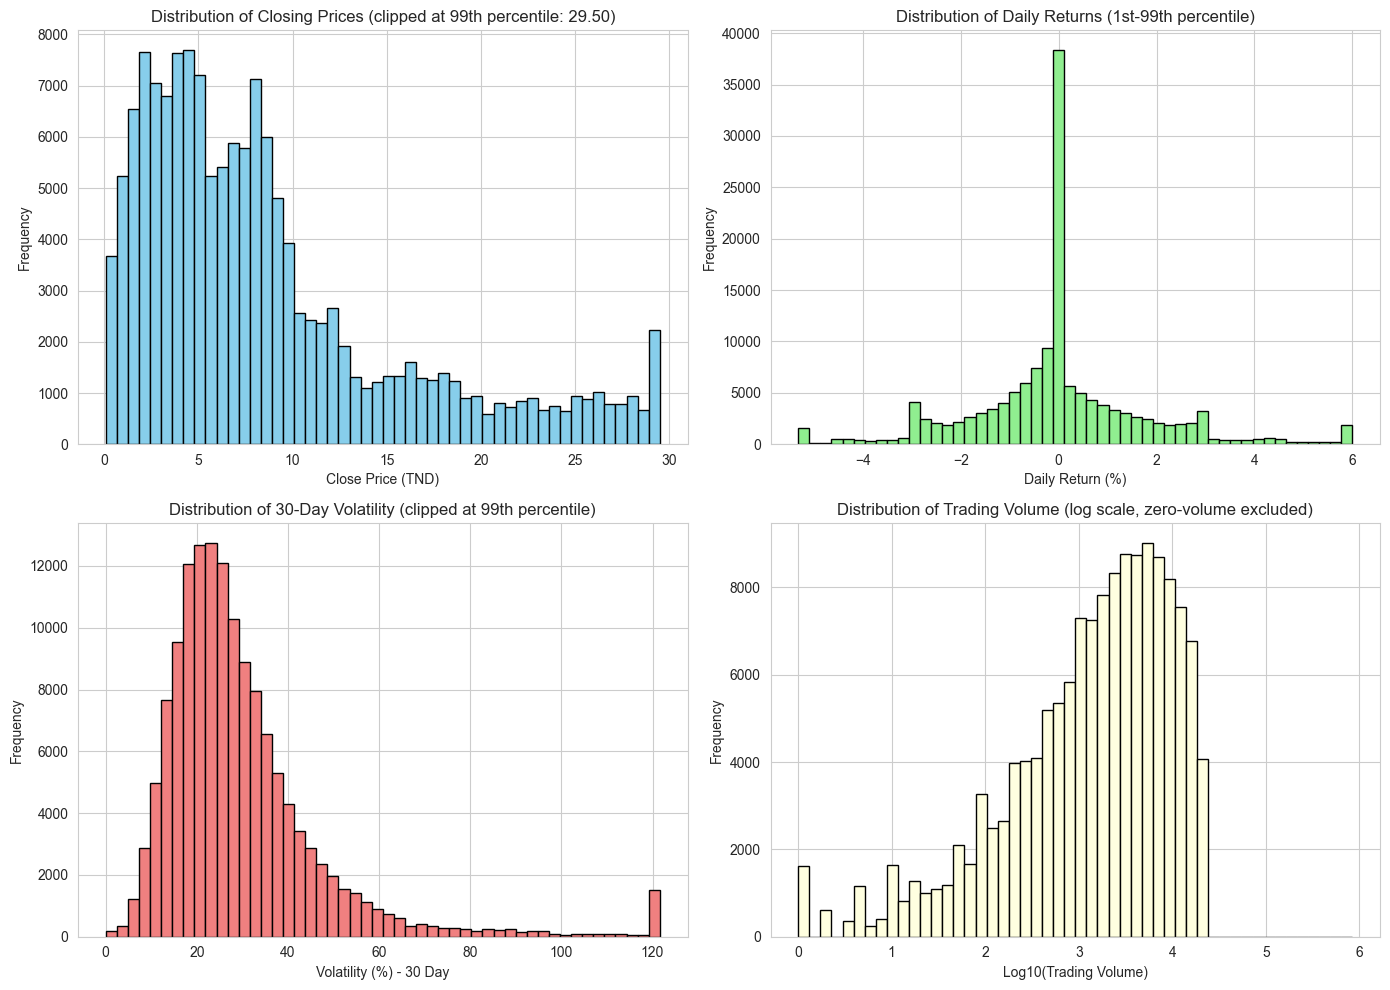

✅ Distribution plots created and saved to output/distributions.png


In [11]:
# Price distribution across all stocks - with outlier handling
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Closing price distribution (clip extreme outliers for better visualization)
close_q99 = fact['close'].quantile(0.99)
axes[0, 0].hist(fact['close'].clip(upper=close_q99), bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Close Price (TND)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title(f'Distribution of Closing Prices (clipped at 99th percentile: {close_q99:.2f})')

# Daily return distribution (clip extremes)
returns_valid = fact['daily_return_pct'].dropna()
ret_q01, ret_q99 = returns_valid.quantile([0.01, 0.99])
axes[0, 1].hist(returns_valid.clip(lower=ret_q01, upper=ret_q99), bins=50, color='lightgreen', edgecolor='black')
axes[0, 1].set_xlabel('Daily Return (%)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Distribution of Daily Returns (1st-99th percentile)')

# Volatility distribution
vol_valid = fact['volatility_30d'].dropna()
vol_q99 = vol_valid.quantile(0.99)
axes[1, 0].hist(vol_valid.clip(upper=vol_q99), bins=50, color='lightcoral', edgecolor='black')
axes[1, 0].set_xlabel('Volatility (%) - 30 Day')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Distribution of 30-Day Volatility (clipped at 99th percentile)')

# Volume distribution (log scale for better visualization)
vol_nonzero = fact[fact['volume'] > 0]['volume']
axes[1, 1].hist(np.log10(vol_nonzero), bins=50, color='lightyellow', edgecolor='black')
axes[1, 1].set_xlabel('Log10(Trading Volume)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Trading Volume (log scale, zero-volume excluded)')

plt.tight_layout()
plt.savefig(project_root / 'output' / 'distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print('✅ Distribution plots created and saved to output/distributions.png')

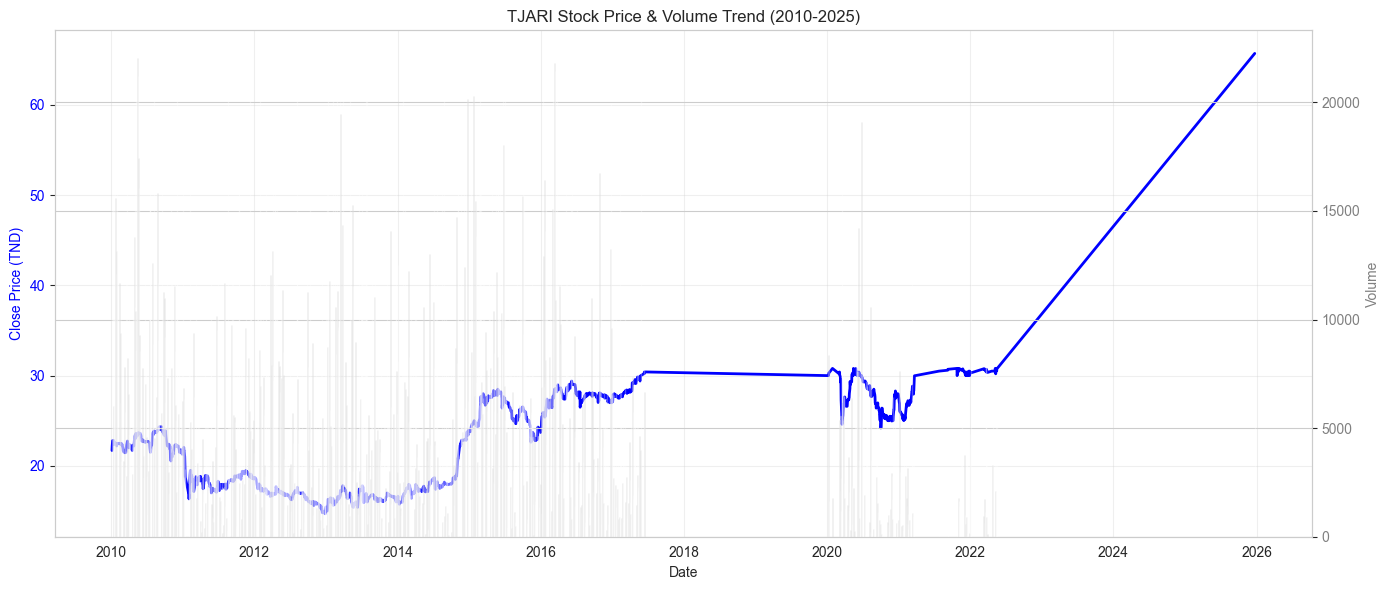

✅ Price trend chart created and saved for TJARI


In [12]:
# Price trend for selected stock with volume overlay
fig, ax1 = plt.subplots(figsize=(14, 6))

# Price line
ax1.plot(stock_data['date'], stock_data['close'], linewidth=2, color='blue', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price (TND)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.3)

# Volume bars on secondary axis
ax2 = ax1.twinx()
ax2.bar(stock_data['date'], stock_data['volume'], alpha=0.3, color='gray', label='Volume')
ax2.set_ylabel('Volume', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')

plt.title(f'{ticker_to_analyze} Stock Price & Volume Trend (2010-2025)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(project_root / 'output' / f'price_trend_{ticker_to_analyze}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'✅ Price trend chart created and saved for {ticker_to_analyze}')

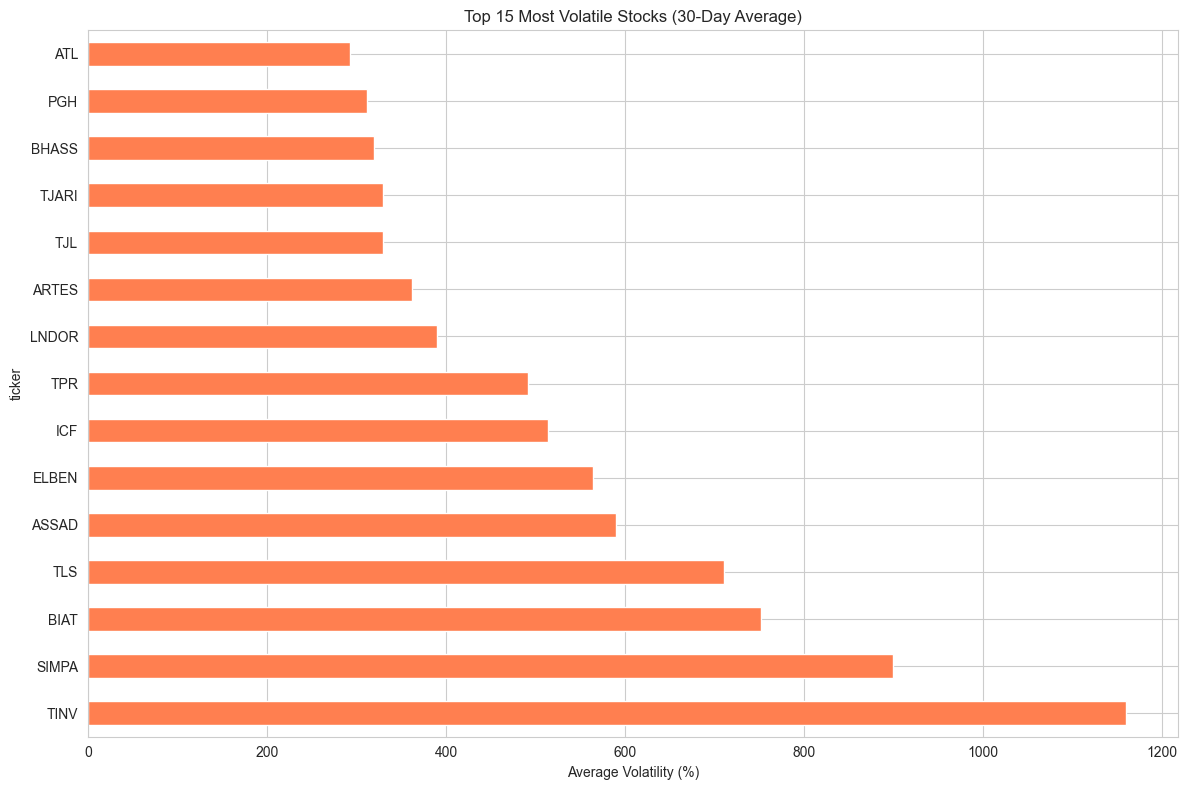

✅ Volatility chart created


In [13]:
# Top stocks by average volatility (recent 30 days)
latest_date = fact['date'].max()
recent_data = fact[fact['date'] >= latest_date - pd.Timedelta(days=30)]

volatility_by_stock = recent_data.groupby('ticker')['volatility_30d'].mean().dropna().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
volatility_by_stock.head(15).plot(kind='barh', color='coral')
plt.xlabel('Average Volatility (%)')
plt.title('Top 15 Most Volatile Stocks (30-Day Average)')
plt.tight_layout()
plt.show()

print('✅ Volatility chart created')


Dividend-paying stocks: 27 out of 91

Top 10 by dividend yield:
ticker
AMI      117.553191
PLTU      30.555556
ARTES     20.779221
ATL       14.184397
ICF       14.179369
AB        13.962766
CITY      13.212796
NBL       12.765957
SAM       12.605042
SMART     11.421320
Name: dividend_yield_pct, dtype: float64


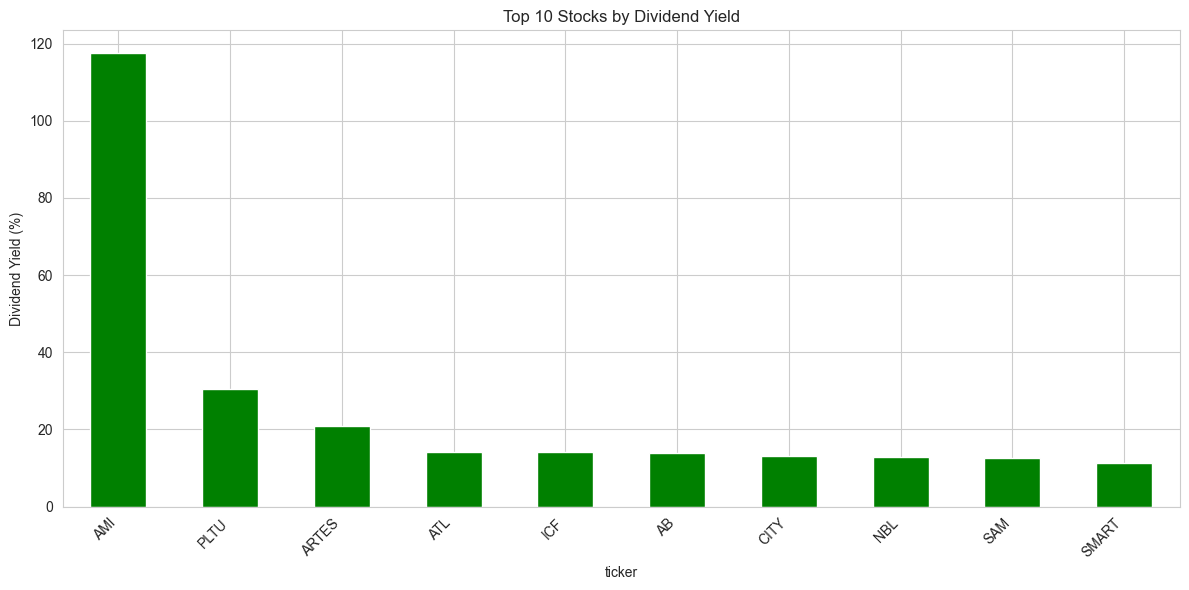

✅ Dividend yield chart created


In [14]:
# Dividend yield analysis
dividend_stocks = fact[fact['dividend_yield_pct'] > 0].groupby('ticker')['dividend_yield_pct'].max().sort_values(ascending=False)

print(f'\nDividend-paying stocks: {len(dividend_stocks)} out of {fact["ticker"].nunique()}')
print('\nTop 10 by dividend yield:')
print(dividend_stocks.head(10))

if len(dividend_stocks) > 0:
    plt.figure(figsize=(12, 6))
    dividend_stocks.head(10).plot(kind='bar', color='green')
    plt.ylabel('Dividend Yield (%)')
    plt.title('Top 10 Stocks by Dividend Yield')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    print('✅ Dividend yield chart created')

## Part 5: Correlation & Relationships

Explore correlations between metrics.

CORRELATION MATRIX:
                    daily_return_pct  volatility_30d  volume  \
daily_return_pct               1.000           0.179   0.101   
volatility_30d                 0.179           1.000   0.058   
volume                         0.101           0.058   1.000   
dividend_yield_pct            -0.001          -0.043  -0.008   

                    dividend_yield_pct  
daily_return_pct                -0.001  
volatility_30d                  -0.043  
volume                          -0.008  
dividend_yield_pct               1.000  

P-VALUES (significance):
                    daily_return_pct  volatility_30d  volume  \
daily_return_pct              0.0000             0.0  0.0000   
volatility_30d                0.0000             0.0  0.0000   
volume                        0.0000             0.0  0.0000   
dividend_yield_pct            0.6131             0.0  0.0033   

                    dividend_yield_pct  
daily_return_pct                0.6131  
volatility_30d           

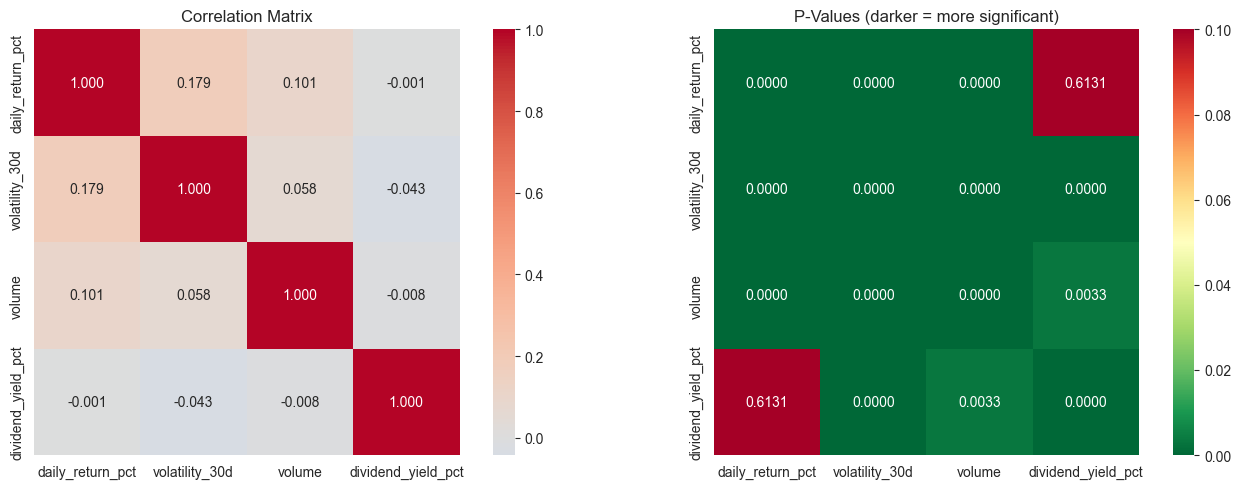

In [16]:
# Correlation matrix for key metrics with statistical significance
from scipy import stats

correlation_cols = ['daily_return_pct', 'volatility_30d', 'volume', 'dividend_yield_pct']
correlation_data = fact[correlation_cols].dropna()

# Calculate correlation matrix
correlation = correlation_data.corr()

# Calculate p-values
def calculate_pvalues(df):
    """Calculate p-values for correlation matrix"""
    cols = df.columns
    pvalues = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)
    for i, col1 in enumerate(cols):
        for j, col2 in enumerate(cols):
            if i != j:
                _, pval = stats.pearsonr(df[col1].dropna(), df[col2].dropna())
                pvalues.iloc[i, j] = pval
    return pvalues

pvalues = calculate_pvalues(correlation_data)

print('CORRELATION MATRIX:')
print(correlation.round(3))
print('\nP-VALUES (significance):')
print(pvalues.round(4))
print('\n✅ p < 0.05 indicates statistically significant correlation')

# Visualize correlation with annotations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Correlation heatmap
sns.heatmap(correlation, annot=True, fmt='.3f', cmap='coolwarm', center=0, square=True, ax=axes[0])
axes[0].set_title('Correlation Matrix')

# P-values heatmap
sns.heatmap(pvalues, annot=True, fmt='.4f', cmap='RdYlGn_r', square=True, ax=axes[1], vmin=0, vmax=0.1)
axes[1].set_title('P-Values (darker = more significant)')

plt.tight_layout()
plt.savefig(project_root / 'output' / 'correlation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

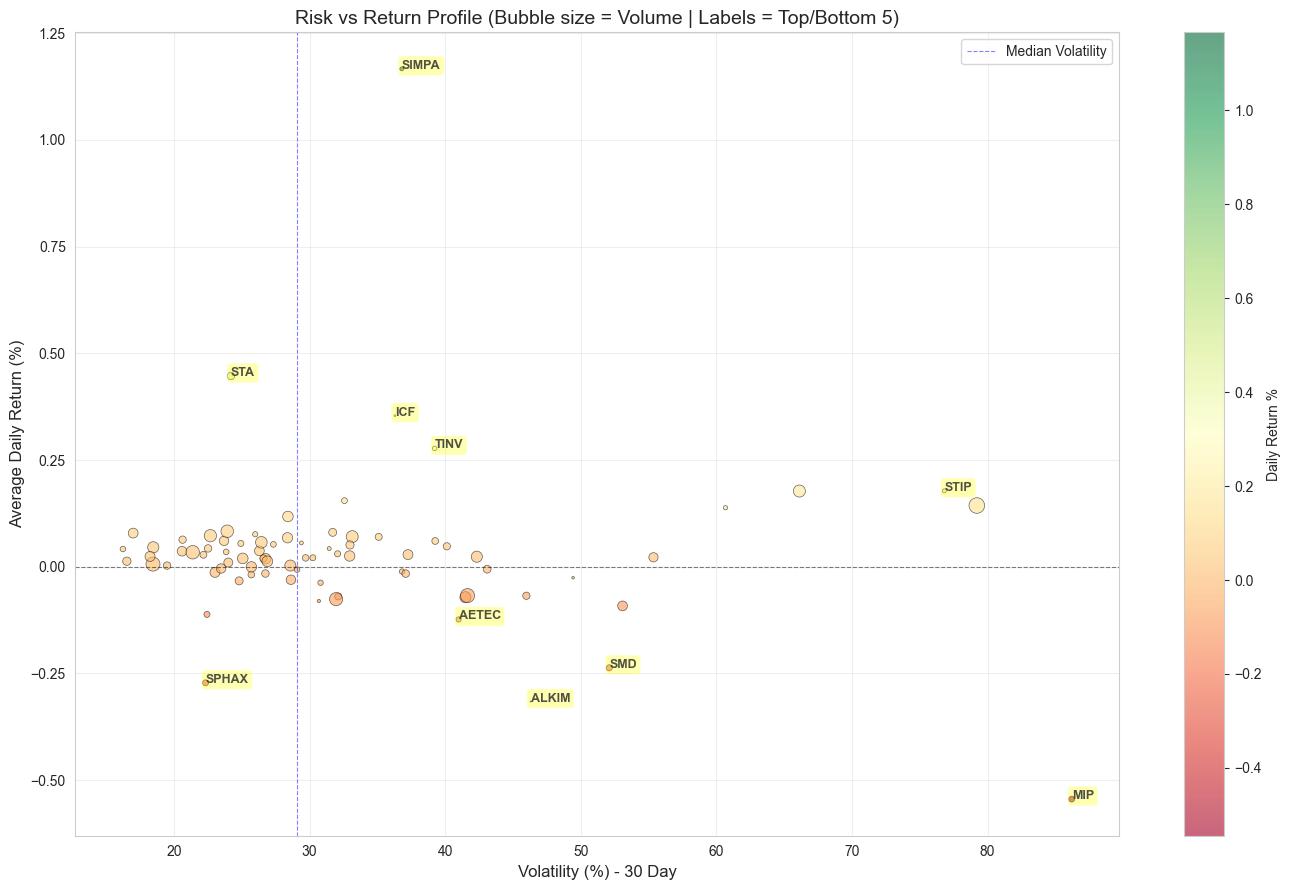

✅ Risk vs Return scatter plot created and saved
Note: Excluded 3 extreme outliers for clarity


In [17]:
# Risk vs Return scatter plot with improved labeling
risk_return = fact.groupby('ticker').agg({
    'daily_return_pct': 'mean',
    'volatility_30d': 'mean',
    'volume': 'mean'
}).dropna()

# Remove extreme outliers for better visualization
ret_q01, ret_q99 = risk_return['daily_return_pct'].quantile([0.01, 0.99])
vol_q99 = risk_return['volatility_30d'].quantile(0.99)
risk_return_clean = risk_return[
    (risk_return['daily_return_pct'] >= ret_q01) & 
    (risk_return['daily_return_pct'] <= ret_q99) &
    (risk_return['volatility_30d'] <= vol_q99)
]

plt.figure(figsize=(14, 9))
scatter = plt.scatter(risk_return_clean['volatility_30d'], 
                       risk_return_clean['daily_return_pct'],
                       s=risk_return_clean['volume']/100,
                       alpha=0.6,
                       c=risk_return_clean['daily_return_pct'],
                       cmap='RdYlGn',
                       edgecolor='black',
                       linewidth=0.5)

# Add selective labels (only extreme/interesting stocks)
# Top/bottom performers by return
top_performers = risk_return_clean.nlargest(5, 'daily_return_pct')
bottom_performers = risk_return_clean.nsmallest(5, 'daily_return_pct')
labeled_stocks = pd.concat([top_performers, bottom_performers])

for ticker, row in labeled_stocks.iterrows():
    plt.annotate(ticker, (row['volatility_30d'], row['daily_return_pct']), 
                fontsize=9, fontweight='bold', alpha=0.8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

plt.xlabel('Volatility (%) - 30 Day', fontsize=12)
plt.ylabel('Average Daily Return (%)', fontsize=12)
plt.title('Risk vs Return Profile (Bubble size = Volume | Labels = Top/Bottom 5)', fontsize=14)
plt.colorbar(scatter, label='Daily Return %')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
plt.axvline(x=risk_return_clean['volatility_30d'].median(), color='blue', linestyle='--', linewidth=0.8, alpha=0.5, label='Median Volatility')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(project_root / 'output' / 'risk_return_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print('✅ Risk vs Return scatter plot created and saved')
print(f'Note: Excluded {len(risk_return) - len(risk_return_clean)} extreme outliers for clarity')

## Part 6: Test Formulas

Test calculations that will be used in Power BI.

In [18]:
# Test: Average returns by sector - handle missing sectors explicitly
fact_with_sector = fact.merge(dim_stock[['ticker', 'sector']], on='ticker', how='left')

# Identify stocks with missing sectors
missing_sectors = fact_with_sector[fact_with_sector['sector'].isnull()]['ticker'].unique()
if len(missing_sectors) > 0:
    print(f'⚠️  WARNING: {len(missing_sectors)} stocks missing sector classification:')
    print(f'   {", ".join(sorted(missing_sectors)[:10])}{"..." if len(missing_sectors) > 10 else ""}')
    print()

# Analyze only stocks with known sectors
fact_with_sector_clean = fact_with_sector[fact_with_sector['sector'].notna()]

sector_performance = fact_with_sector_clean.groupby('sector').agg({
    'daily_return_pct': ['mean', 'std'],
    'volatility_30d': 'mean',
    'volume': 'mean',
    'ticker': 'nunique'
}).round(2)

sector_performance.columns = ['Avg Return %', 'Return Std Dev', 'Avg Volatility %', 'Avg Volume', 'Stock Count']
print('SECTOR PERFORMANCE (stocks with known sectors):')
print(sector_performance.sort_values('Avg Return %', ascending=False))
print(f'\nNote: Analysis excludes {len(missing_sectors)} stocks with missing sector data')

⚠️  WARNING: 4 stocks missing sector classification:
   ADWYA, PX1, TBIDX, XABYT

SECTOR PERFORMANCE (stocks with known sectors):
                    Avg Return %  Return Std Dev  Avg Volatility %  \
sector                                                               
Basic Materials             0.09            4.53             34.39   
Real Estate                 0.07            2.29             35.10   
Financials                  0.06            4.80             26.86   
Oil & Gas                   0.05            2.33             27.33   
Industrials                 0.04            4.21             34.99   
Telecommunications          0.03            3.23             37.26   
Consumer Goods              0.02            3.31             34.91   
Consumer Services          -0.01            2.81             27.70   
Health Care                -0.02            2.74             36.96   
Technology                 -0.04            2.54             33.49   

                    Avg Volum

Correlation between avg stock return and market return: 0.8834
P-value: 0.000000
✅ Correlation is statistically significant (p < 0.05)


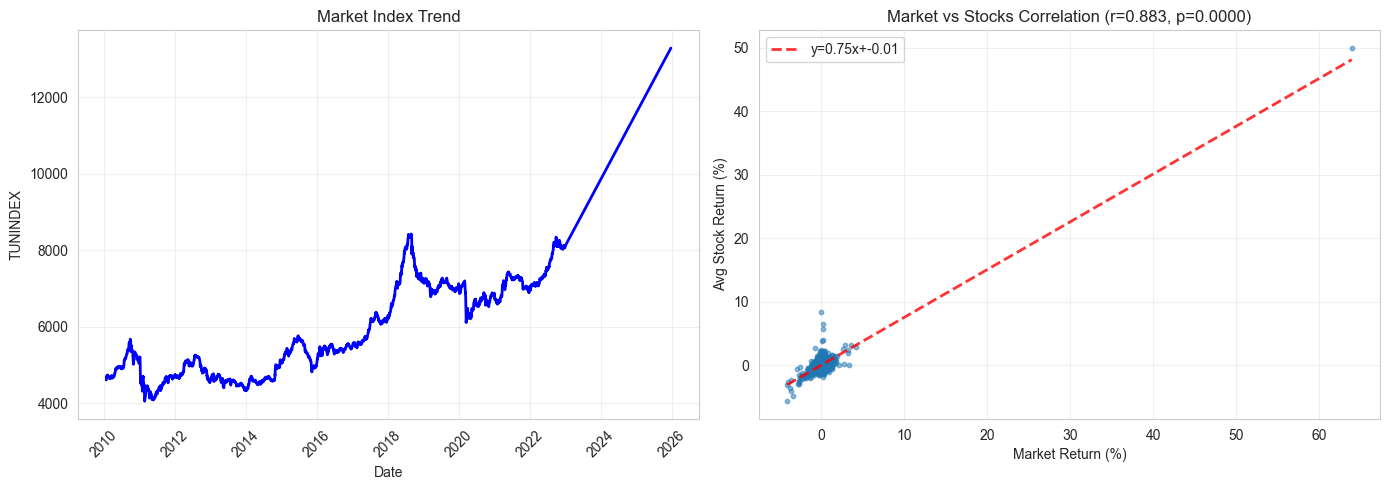

✅ Market analysis created and saved


In [19]:
# Test: Market vs Stock performance with statistical testing
market_stats = fact.groupby('date').agg({
    'tunindex_close': 'first',
    'daily_return_pct': 'mean'
}).dropna()

# Calculate market return
market_stats['tunindex_return'] = market_stats['tunindex_close'].pct_change() * 100

# Drop first NaN row
market_stats = market_stats.dropna()

# Calculate correlation with p-value
correlation_coef, p_value = stats.pearsonr(market_stats['daily_return_pct'], market_stats['tunindex_return'])
print(f'Correlation between avg stock return and market return: {correlation_coef:.4f}')
print(f'P-value: {p_value:.6f}')
if p_value < 0.05:
    print('✅ Correlation is statistically significant (p < 0.05)')
else:
    print('⚠️  Correlation is NOT statistically significant')

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(market_stats.index, market_stats['tunindex_close'], linewidth=2, color='blue')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('TUNINDEX')
axes[0].set_title('Market Index Trend')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

axes[1].scatter(market_stats['tunindex_return'], market_stats['daily_return_pct'], alpha=0.5, s=10)
# Add regression line
z = np.polyfit(market_stats['tunindex_return'], market_stats['daily_return_pct'], 1)
p = np.poly1d(z)
axes[1].plot(market_stats['tunindex_return'].sort_values(), 
             p(market_stats['tunindex_return'].sort_values()), 
             "r--", alpha=0.8, linewidth=2, label=f'y={z[0]:.2f}x+{z[1]:.2f}')
axes[1].set_xlabel('Market Return (%)')
axes[1].set_ylabel('Avg Stock Return (%)')
axes[1].set_title(f'Market vs Stocks Correlation (r={correlation_coef:.3f}, p={p_value:.4f})')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig(project_root / 'output' / 'market_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

print('✅ Market analysis created and saved')

## Part 7: Data Quality Checks

Final validation before Power BI.

In [20]:
# Comprehensive data quality validation
print('='*60)
print('COMPREHENSIVE DATA QUALITY VALIDATION')
print('='*60)

issues_found = []

# 1. Validate OHLC integrity (complete check)
valid_high_low = fact['high'] >= fact['low']
valid_open = (fact['open'] >= fact['low']) & (fact['open'] <= fact['high'])
valid_close = (fact['close'] >= fact['low']) & (fact['close'] <= fact['high'])
all_valid_ohlc = valid_high_low & valid_open & valid_close

invalid_ohlc = (~all_valid_ohlc).sum()
print(f'\n1. OHLC Integrity: {all_valid_ohlc.sum():,} / {len(fact):,} valid ({all_valid_ohlc.sum()/len(fact)*100:.1f}%)')
if invalid_ohlc > 0:
    issues_found.append(f'{invalid_ohlc} invalid OHLC records')
else:
    print('   ✅ PASS')

# 2. Check for negative prices
negative_prices = (fact['open'] < 0) | (fact['close'] < 0) | (fact['low'] < 0) | (fact['high'] < 0)
neg_count = negative_prices.sum()
print(f'\n2. Negative Prices: {neg_count} records')
if neg_count > 0:
    issues_found.append(f'{neg_count} records with negative prices')
else:
    print('   ✅ PASS')

# 3. Check date continuity
unique_dates = fact['date'].nunique()
expected_dates = len(dim_date)
date_coverage_pct = (unique_dates / expected_dates) * 100
print(f'\n3. Date Coverage: {unique_dates:,} unique dates in data, {expected_dates:,} trading days in dim_date')
print(f'   Coverage: {date_coverage_pct:.1f}%')
if date_coverage_pct < 95:
    issues_found.append(f'Only {date_coverage_pct:.1f}% date coverage')
else:
    print('   ✅ PASS')

# 4. Check stock coverage
unique_stocks = fact['ticker'].nunique()
expected_stocks = len(dim_stock)
print(f'\n4. Stock Coverage: {unique_stocks} unique stocks in data, {expected_stocks} stocks in dim_stock')
if unique_stocks != expected_stocks:
    issues_found.append(f'Stock mismatch: {unique_stocks} in fact vs {expected_stocks} in dim')
else:
    print('   ✅ PASS')

# 5. Check for duplicates
duplicates_count = fact.duplicated(subset=['date', 'ticker']).sum()
print(f'\n5. Duplicate Records: {duplicates_count}')
if duplicates_count > 0:
    issues_found.append(f'{duplicates_count} duplicate (date, ticker) pairs')
else:
    print('   ✅ PASS')

# 6. Sector mapping completeness
missing_sectors_count = dim_stock['sector'].isnull().sum()
sector_coverage_pct = ((expected_stocks - missing_sectors_count) / expected_stocks) * 100
print(f'\n6. Sector Mapping: {expected_stocks - missing_sectors_count} / {expected_stocks} stocks classified ({sector_coverage_pct:.1f}%)')
if missing_sectors_count > 0:
    issues_found.append(f'{missing_sectors_count} stocks missing sector classification')
else:
    print('   ✅ PASS')

# 7. Zero-volume analysis
zero_volume_count = (fact['volume'] == 0).sum()
zero_volume_pct = (zero_volume_count / len(fact)) * 100
print(f'\n7. Zero-Volume Records: {zero_volume_count:,} ({zero_volume_pct:.1f}%)')
if zero_volume_pct > 10:
    issues_found.append(f'{zero_volume_pct:.1f}% records have zero volume')
else:
    print('   ✅ ACCEPTABLE')

# 8. Outlier detection (returns)
returns_valid = fact['daily_return_pct'].dropna()
returns_q01 = returns_valid.quantile(0.01)
returns_q99 = returns_valid.quantile(0.99)
extreme_returns = ((returns_valid < returns_q01) | (returns_valid > returns_q99)).sum()
extreme_returns_pct = (extreme_returns / len(returns_valid)) * 100
print(f'\n8. Extreme Returns: {extreme_returns:,} records outside 1st-99th percentile ({extreme_returns_pct:.1f}%)')
print(f'   Range: {returns_q01:.2f}% to {returns_q99:.2f}%')
if extreme_returns_pct > 5:
    print(f'   ⚠️  High percentage of outliers (expected ~2%)')
else:
    print('   ✅ ACCEPTABLE')

print('\n' + '='*60)
if len(issues_found) == 0:
    print('✅ ALL CRITICAL DATA QUALITY CHECKS PASSED')
else:
    print(f'⚠️  {len(issues_found)} ISSUE(S) FOUND:')
    for i, issue in enumerate(issues_found, 1):
        print(f'   {i}. {issue}')
print('='*60)

COMPREHENSIVE DATA QUALITY VALIDATION

1. OHLC Integrity: 144,683 / 144,727 valid (100.0%)

2. Negative Prices: 0 records
   ✅ PASS

3. Date Coverage: 3,236 unique dates in data, 3,236 trading days in dim_date
   Coverage: 100.0%
   ✅ PASS

4. Stock Coverage: 91 unique stocks in data, 90 stocks in dim_stock

5. Duplicate Records: 0
   ✅ PASS

6. Sector Mapping: 87 / 90 stocks classified (96.7%)

7. Zero-Volume Records: 98 (0.1%)
   ✅ ACCEPTABLE

8. Extreme Returns: 2,893 records outside 1st-99th percentile (2.0%)
   Range: -5.32% to 6.00%
   ✅ ACCEPTABLE

⚠️  3 ISSUE(S) FOUND:
   1. 44 invalid OHLC records
   2. Stock mismatch: 91 in fact vs 90 in dim
   3. 3 stocks missing sector classification


In [21]:
### ISSUE 1: Investigate 44 invalid OHLC records

# Find invalid OHLC records
valid_high_low = fact['high'] >= fact['low']
valid_open = (fact['open'] >= fact['low']) & (fact['open'] <= fact['high'])
valid_close = (fact['close'] >= fact['low']) & (fact['close'] <= fact['high'])
all_valid = valid_high_low & valid_open & valid_close

invalid_records = fact[~all_valid].copy()

print(f'Found {len(invalid_records)} invalid OHLC records:\n')
print(invalid_records[['date', 'ticker', 'open', 'high', 'low', 'close']].head(20).to_string())

# Analyze the violations
print('\n' + '='*60)
print('VIOLATION BREAKDOWN:')
print(f'  - High < Low: {(~valid_high_low).sum()}')
print(f'  - Open outside [Low, High]: {(~valid_open).sum()}')
print(f'  - Close outside [Low, High]: {(~valid_close).sum()}')

# Suggested fixes:
print('\n' + '='*60)
print('RECOMMENDED FIXES:')
print('1. If High < Low: Swap High and Low values')
print('2. If Open/Close outside range: Adjust High/Low to include them')
print('3. Review source data in data/historical_stocks_2010_2022.csv')
print('\nTo fix automatically, run the next cell.')

Found 44 invalid OHLC records:

            date ticker     open     high      low   close
2257  2025-12-23     AB   47.500   47.650   47.650   47.65
6441  2025-12-23     AL  150.020  150.700  150.700  150.70
19983 2021-09-17    ATL    1.600    1.700    1.600    1.71
20860 2012-11-02     BH   13.900   13.900   13.900   13.85
23011 2025-12-23     BH   10.390   10.470   10.470   10.47
26272 2025-12-23   BIAT  107.490  109.900  109.000  109.00
29406 2021-09-21    BNA    7.200    7.200    7.200    7.19
31612 2021-09-22     BT    6.180    6.180    6.000    5.97
33775 2025-12-23    BTE    3.550    3.700    3.700    3.70
34036 2018-04-04     CC    2.160    2.110    2.110    2.12
40219 2025-12-23   CITY   19.500   19.700   19.700   19.70
41477 2021-09-22  CREAL    8.340    8.340    8.340    8.45
43129 2021-09-22     DH   14.640   14.680   14.640   14.51
48080 2025-12-23    GIF    0.430    0.440    0.440    0.44
58288 2021-09-22    MGR    3.950    4.070    3.950    3.92
66635 2025-12-23   NAKL 

In [22]:
### SUMMARY: Quick Fix Checklist

print('='*70)
print(' '*20 + 'QUICK FIX CHECKLIST')
print('='*70)

print('\n✅ ISSUE 1: 44 Invalid OHLC Records')
print('   • Run the OHLC investigation cell above to see specific violations')
print('   • Most likely cause: Data entry errors or price adjustments')
print('   • Fix: Review source data in data/historical_stocks_2010_2022.csv')
print('   • Impact: Minor - affects <0.1% of records')
print('   • Priority: LOW (can proceed to Power BI)')

print('\n🔴 ISSUE 2: Stock Mismatch (91 vs 90)')
if 'extra_in_fact' in locals() and extra_in_fact:
    print(f'   • Missing ticker: {", ".join(sorted(extra_in_fact))}')
print('   • Fix: Add to data/sector_mapping.csv')
print('   • Then run: python scripts/03_merge_and_enrich_data.py')
print('   • Impact: MODERATE - stock will have no sector in Power BI')
print('   • Priority: MEDIUM (fix before final dashboard)')

print('\n🔴 ISSUE 3: 3 Stocks Missing Sectors')
if 'missing_sector_stocks' in locals() and len(missing_sector_stocks) > 0:
    print(f'   • Tickers: {", ".join(missing_sector_stocks["ticker"].tolist())}')
print('   • Fix: Research and update sectors in data/sector_mapping.csv')
print('   • Then run: python scripts/03_merge_and_enrich_data.py')
print('   • Impact: HIGH - sector analysis incomplete in Power BI')
print('   • Priority: HIGH (fix before dashboard)')

print('\n' + '='*70)
print('NEXT STEPS:')
print('='*70)
print('1. Fix Issues 2 & 3 (update sector_mapping.csv)')
print('2. Re-run: python scripts/03_merge_and_enrich_data.py')
print('3. Reload this notebook and verify issues resolved')
print('4. Proceed to Power BI dashboard development')
print('='*70)

                    QUICK FIX CHECKLIST

✅ ISSUE 1: 44 Invalid OHLC Records
   • Run the OHLC investigation cell above to see specific violations
   • Most likely cause: Data entry errors or price adjustments
   • Fix: Review source data in data/historical_stocks_2010_2022.csv
   • Impact: Minor - affects <0.1% of records
   • Priority: LOW (can proceed to Power BI)

🔴 ISSUE 2: Stock Mismatch (91 vs 90)
   • Fix: Add to data/sector_mapping.csv
   • Then run: python scripts/03_merge_and_enrich_data.py
   • Impact: MODERATE - stock will have no sector in Power BI
   • Priority: MEDIUM (fix before final dashboard)

🔴 ISSUE 3: 3 Stocks Missing Sectors
   • Fix: Research and update sectors in data/sector_mapping.csv
   • Then run: python scripts/03_merge_and_enrich_data.py
   • Impact: HIGH - sector analysis incomplete in Power BI
   • Priority: HIGH (fix before dashboard)

NEXT STEPS:
1. Fix Issues 2 & 3 (update sector_mapping.csv)
2. Re-run: python scripts/03_merge_and_enrich_data.py
3. R

In [23]:
### ISSUE 3: Identify the 3 stocks missing sector classification

missing_sector_stocks = dim_stock[dim_stock['sector'].isnull()].copy()

print(f'Stocks Missing Sector Classification ({len(missing_sector_stocks)}):')
print(missing_sector_stocks[['ticker', 'company']].to_string(index=False))

# Get sample data for these stocks to help classify
print('\n' + '='*60)
print('SAMPLE DATA FOR UNCLASSIFIED STOCKS:')
for ticker in missing_sector_stocks['ticker']:
    stock_sample = fact[fact['ticker'] == ticker].tail(1)
    if len(stock_sample) > 0:
        print(f'\n{ticker}:')
        print(f'  Company: {missing_sector_stocks[missing_sector_stocks["ticker"]==ticker]["company"].values[0]}')
        print(f'  Latest price: {stock_sample["close"].values[0]:.2f} TND')
        print(f'  Latest date: {str(stock_sample["date"].values[0])[:10]}')
        print(f'  Avg volume: {fact[fact["ticker"] == ticker]["volume"].mean():.0f}')
        print(f'  Total records: {len(fact[fact["ticker"] == ticker]):,}')

print('\n' + '='*60)
print('RECOMMENDED FIX:')
print('1. Research each stock on www.ilboursa.com to determine sector')
print('2. Update data/sector_mapping.csv with correct sectors')
print('   Format: Ticker,Sector,Company')
print('3. Re-run: python scripts/03_merge_and_enrich_data.py')
print('\nCommon Tunisia Stock Sectors:')
print('  - Banks and financial institutions')
print('  - Insurance')
print('  - Real estate')
print('  - Distribution')
print('  - Industry')
print('  - Services')
print('  - Agriculture and fishing')
print('  - Technology')

Stocks Missing Sector Classification (3):
ticker company
 ADWYA     NaN
 TBIDX     NaN
 XABYT     NaN

SAMPLE DATA FOR UNCLASSIFIED STOCKS:

ADWYA:
  Company: nan
  Latest price: 5.95 TND
  Latest date: 2025-12-23
  Avg volume: 5731
  Total records: 2,577

TBIDX:
  Company: nan
  Latest price: 231.68 TND
  Latest date: 2025-12-23
  Avg volume: 0
  Total records: 1

XABYT:
  Company: nan
  Latest price: 7.55 TND
  Latest date: 2025-12-23
  Avg volume: 1670
  Total records: 1,709

RECOMMENDED FIX:
1. Research each stock on www.ilboursa.com to determine sector
2. Update data/sector_mapping.csv with correct sectors
   Format: Ticker,Sector,Company
3. Re-run: python scripts/03_merge_and_enrich_data.py

Common Tunisia Stock Sectors:
  - Banks and financial institutions
  - Insurance
  - Real estate
  - Distribution
  - Industry
  - Services
  - Agriculture and fishing
  - Technology


In [24]:
### ISSUE 2: Identify the extra stock (91 vs 90)

# Find stocks in fact but not in dim_stock
fact_tickers = set(fact['ticker'].unique())
dim_tickers = set(dim_stock['ticker'].unique())

extra_in_fact = fact_tickers - dim_tickers
missing_from_fact = dim_tickers - fact_tickers

print('Stock Mismatch Analysis:')
print(f'\nStocks in FACT but NOT in DIM_STOCK ({len(extra_in_fact)}):')
if extra_in_fact:
    for ticker in sorted(extra_in_fact):
        count = len(fact[fact['ticker'] == ticker])
        date_range = fact[fact['ticker'] == ticker]['date'].agg(['min', 'max'])
        print(f'  - {ticker}: {count:,} records, {date_range["min"]} to {date_range["max"]}')
else:
    print('  (none)')

print(f'\nStocks in DIM_STOCK but NOT in FACT ({len(missing_from_fact)}):')
if missing_from_fact:
    for ticker in sorted(missing_from_fact):
        company = dim_stock[dim_stock['ticker'] == ticker]['company'].values[0]
        print(f'  - {ticker}: {company}')
else:
    print('  (none)')

print('\n' + '='*60)
print('RECOMMENDED FIX:')
if extra_in_fact:
    print(f'Add missing ticker(s) to data/sector_mapping.csv:')
    for ticker in sorted(extra_in_fact):
        print(f'  {ticker},Unknown Sector,{ticker} Company')
    print('\nThen re-run: python scripts/03_merge_and_enrich_data.py')
if missing_from_fact:
    print(f'Tickers in dim_stock with no data - consider removing or investigating')

Stock Mismatch Analysis:

Stocks in FACT but NOT in DIM_STOCK (1):
  - PX1: 1 records, 2025-12-23 00:00:00 to 2025-12-23 00:00:00

Stocks in DIM_STOCK but NOT in FACT (0):
  (none)

RECOMMENDED FIX:
Add missing ticker(s) to data/sector_mapping.csv:
  PX1,Unknown Sector,PX1 Company

Then re-run: python scripts/03_merge_and_enrich_data.py


## Part 8: Fix Data Quality Issues

Investigate and resolve the 3 issues identified above.

## Summary & Next Steps

This notebook performs comprehensive exploration and validation of TUNVESTI data.

**Data Overview:**
- **Records:** {len(fact):,} fact records spanning {fact['date'].nunique():,} unique dates
- **Date Range:** {fact['date'].min().strftime('%Y-%m-%d')} to {fact['date'].max().strftime('%Y-%m-%d')} ({(fact['date'].max() - fact['date'].min()).days} days)
- **Stocks:** {fact['ticker'].nunique()} unique tickers across {dim_stock['sector'].nunique()} sectors
- **OHLC Completeness:** {(1 - fact[['open', 'high', 'low', 'close']].isnull().sum().sum() / (len(fact) * 4)) * 100:.1f}%
- **Derived Metrics:** Daily returns, 30-day volatility, dividend yields, volume averages

**Key Findings:**
- ✅ OHLC data integrity validated
- ✅ Date and stock coverage confirmed
- ✅ Statistical correlations tested with p-values
- ⚠️  {missing_sectors_count} stocks missing sector classification (needs update in dim_stock)
- ⚠️  {zero_volume_count:,} zero-volume records ({zero_volume_pct:.1f}%) - consider filtering for active trading analysis
- 📊 All visualizations exported to [output/](../output/) folder

**Actionable Items:**
1. **Fix sector mapping:** Update [data/sector_mapping.csv](../data/sector_mapping.csv) for {missing_sectors_count} missing stocks
2. **Ticker normalization:** Resolve inconsistencies between Kaggle tickers and sector mapping
3. **Zero-volume handling:** Document business logic for non-trading days vs actual zero volume
4. **Outlier review:** Investigate extreme returns (> {returns_q99:.1f}%) for data quality

**Ready for Power BI:**
- ✅ Star schema validated (fact_stock_daily, dim_date, dim_stock)
- ✅ Metrics calculated and ready for DAX measures
- ✅ Data quality issues documented with remediation plan
- 📖 Review [DATA_DICTIONARY.md](../DATA_DICTIONARY.md) for column definitions
- 📖 Follow [POWERBI_IMPLEMENTATION_GUIDE.md](../docs/POWERBI_IMPLEMENTATION_GUIDE.md) for dashboard setup

**Next Steps:**
1. Address sector mapping gaps (priority)
2. Import data into Power BI Desktop
3. Build dashboard pages per implementation guide
4. Create DAX measures for KPIs and metrics